# Machine learning lab #1 (kNN)

### Andosov German, M33391

##### Part 2. «k Nearest Neighbors» algorithm implementation

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from enum import Enum
from math import exp, pi, sqrt
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier

pd.options.mode.copy_on_write = True
pd.set_option('display.max_columns', 65)

In [35]:
DATASET_PATH = "fifa_normalized.csv"
df = pd.read_csv(DATASET_PATH)
df

,Overall,Value,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Height,Weight,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,DefensiveAwareness,Best Position
0,0.896111,0.965300,0,0.999996,0.547103,0.769853,0.457923,0.409362,0.879275,0.840352,0.515232,0.918718,0.961344,0.727446,0.901025,0.929051,0.901692,0.774070,0.599796,0.527474,0.679205,0.947359,0.671440,0.891907,0.597983,0.869276,0.532252,0.925449,0.721795,0.698950,0.849059,0.914339,0.969827,0.827760,0.743653,0.679448,0.876573,0.888964,0.896493,0.816781,0.893601,0.741215,3
1,0.875220,0.956391,0,1.000000,0.781001,0.529873,0.655502,0.623446,0.686483,0.827317,0.870583,0.792544,0.733171,0.746755,0.750452,0.805946,0.826370,0.774070,0.617249,0.704963,0.608442,0.895279,0.537595,0.822224,0.699604,0.807544,0.830810,0.881511,0.768519,0.939282,0.816853,0.815324,0.535678,0.738529,0.896343,0.821466,0.885996,0.811673,0.896493,0.863934,0.836564,0.765440,2
2,0.896111,0.908532,0,1.000000,0.781001,0.529873,0.516792,0.638677,0.764595,0.972991,0.835028,0.722278,1.000000,0.727446,0.887080,0.877996,0.701733,0.751131,0.582608,0.464058,0.591339,0.964844,0.653979,0.891907,0.533665,0.619045,0.777327,0.910736,0.865054,0.405726,0.914938,0.815324,0.851603,0.827760,0.403167,0.363337,0.949556,0.941042,0.955119,0.960673,0.967473,0.391017,3
3,0.958556,0.974645,0,1.000000,1.000000,0.769853,0.497130,0.427009,1.000000,0.827317,0.393272,1.000000,0.897297,0.826735,0.873186,0.888233,1.000000,0.870106,0.582608,0.577861,0.661161,0.947359,0.653979,0.927467,0.442423,0.827854,0.593920,0.955074,0.691229,0.698950,0.865346,0.982642,0.851603,0.864748,0.643921,0.538286,0.901446,0.880502,0.716840,0.851008,0.885339,0.693056,2
4,0.812309,0.895855,1,0.999577,0.547103,0.769853,0.321941,0.409362,0.879275,0.624889,0.432363,0.699743,0.720700,0.806327,0.915019,0.805946,0.718976,0.797434,0.599796,0.577861,0.734749,0.809760,0.877216,0.771236,0.442423,0.848431,0.691470,0.809641,0.816277,0.854682,0.753927,0.783253,0.751532,0.827760,0.883486,0.880862,0.818746,0.888964,0.880604,0.884423,0.893601,0.838672,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15566,0.114594,0.369638,0,0.000000,0.547103,0.000000,0.635572,0.638677,0.025401,0.038233,0.025753,0.021109,0.008827,0.009181,0.041564,0.080422,0.040506,0.006538,0.016397,0.000000,0.012629,0.248080,0.128461,0.130462,0.266907,0.013421,0.403525,0.004495,0.106310,0.103664,0.013233,0.077378,0.018869,0.116933,0.046133,0.044085,0.983304,0.974887,0.976658,0.982013,0.986098,0.024363,0
15567,0.249775,0.469538,0,0.000000,0.291731,0.000000,0.775873,0.668671,0.003542,0.038233,0.017708,0.023898,0.027124,0.007323,0.034069,0.093208,0.030468,0.005208,0.035709,0.034859,0.043935,0.178911,0.004750,0.205162,0.000000,0.023921,0.487789,0.020053,0.060256,0.000000,0.004335,0.108219,0.000000,0.087327,0.046133,0.044085,0.987205,0.986664,0.983862,0.984158,0.988490,0.015992,0
15568,0.137293,0.377168,0,0.000000,0.291731,0.000000,0.755717,0.683442,0.025401,0.024359,0.014070,0.009994,0.027124,0.000784,0.034069,0.118419,0.097033,0.009650,0.007299,0.022208,0.062632,0.125457,0.026009,0.182991,0.104025,0.036317,0.088042,0.009359,0.039872,0.092973,0.013233,0.159908,0.032700,0.087327,0.055762,0.066362,0.985986,0.981130,0.981701,0.978785,0.986723,0.015992,0
15569,0.000000,0.297314,0,0.000000,0.291731,0.000000,0.477507,0.444440,0.020509,0.038233,0.030151,0.006763,0.017880,0.002863,0.041564,0.118419,0.017195,0.002969,0.027351,0.005328,0.106156,0.192542,0.111185,0.120467,0.279304,0.020213,0.277189,0.020053,0.010215,0.071762,0.009973,0.043224,0.055056,0.019024,0.036624,0.032999,0.980233,0.977

Let's define our supported kernels at first:

In [36]:
class Kernel(Enum):
    UNIFORM = lambda x: 0.5 if -1 < x < 1 else 0
    TRIANGULAR = lambda x: max(0, 1 - abs(x))
    EPANECHNIKOV = lambda x: max(0, 0.75 * (1 - x ** 2))
    GAUSSIAN = lambda x: 1 / sqrt(2 * pi) * exp(- (x ** 2 / 2))


    def __init__(self, func):
        self.apply = func

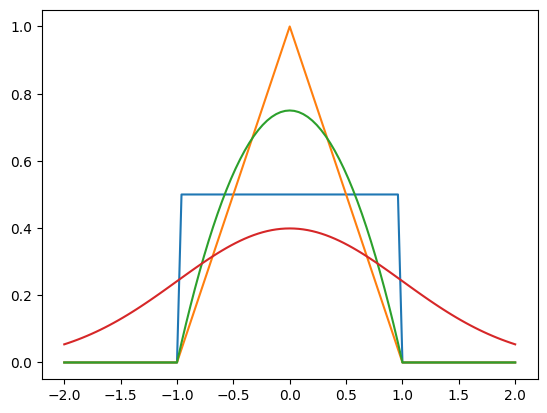

In [37]:
for kernel in [Kernel.UNIFORM, Kernel.TRIANGULAR, Kernel.EPANECHNIKOV, Kernel.GAUSSIAN]:
    xs = np.linspace(-2, 2, 101)
    ys = [kernel(x) for x in xs]
    plt.plot(xs, ys)

plt.show()

There are supported metrics and a enum for window types:

In [38]:
class WindowType(Enum):
    FIXED = 1
    VARIABLE = 2


class Metric(Enum):
    MANHATTAN = 1
    EUCLIDEAN = 2
    COSINE = 3

Algorithm implementation implements fit-predict interface.

<details>
  <summary><i>Secret knowledge</i></summary>
  <img src="rosenblatt.png" width="1000" height="400"></img>
</details>

In [39]:
class KNN:
    def __init__(
        self,
        window_param: int,
        window_type: WindowType,
        kernel: Kernel,
        metric: Metric,
    ):
        self.window_type = window_type
        if window_type == WindowType.FIXED:
            self.h = window_param
        else:
            self.k = window_param
        self.kernel = kernel
        self.metric = metric


    def fit(self, X, y, w):
        self.X_train = X
        self.y_train = y
        self.w = w
        self.class_count = len(self.y_train.value_counts())
        return self


    def predict(self, X):
        predictions = []
        all_distances, all_classes, all_weights = self._find_neighbors(X)
        for obj_id in range(len(X)):
            distances, classes, weights = all_distances[obj_id], all_classes[obj_id], all_weights[obj_id]
            scores = [0 for _ in range(self.class_count)]
            for i in range(len(distances) - 1): # skipping last "extra neighbor"
                kernel_arg = distances[i] / (self.h if self.window_type == WindowType.FIXED else distances[-1])
                scores[classes[i]] += self.kernel(kernel_arg) * weights[i]
            predictions.append(scores.index(max(scores)))
        return predictions


    def _find_neighbors(self, X): # returns distance, class and weight for each neighbor (including one "extra neighbor")
        neighbors_count = self.k + 1 if self.window_type == WindowType.VARIABLE else len(self.X_train) - 1
        nn = NearestNeighbors(n_neighbors=neighbors_count, metric=self.metric.name.lower())
        nn.fit(self.X_train)
        distances, ids = nn.kneighbors(X, n_neighbors=neighbors_count)
        classes, weights = [], []
        for i in ids:
            classes.append(self.y_train.iloc[i].to_list())
            weights.append([self.w[j] for j in i])
        return (distances, classes, weights)


Let's split our data into train and test:

In [40]:
train, test = np.split(df.sample(frac=1, random_state=17), [int(.8*len(df))])
print("Train and test sizes: ", len(train), len(test))
X_train = train.drop(columns=["Best Position"])
y_train = train["Best Position"]
X_test = test.drop(columns=["Best Position"])
y_test = test["Best Position"]

Train and test sizes:  12456 3115


/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Time to test our implementation (hyperparameters are arbitrary):

In [41]:
my_knn = KNN(window_param=10, window_type=WindowType.VARIABLE, kernel=Kernel.UNIFORM, metric=Metric.EUCLIDEAN)
predictions = my_knn.fit(X_train, y_train, [1 for _ in range(len(X_train))]).predict(X_test)
pd.DataFrame(predictions).value_counts()

1    1030
2     982
3     818
0     285
Name: count, dtype: int64

In [42]:
def accuracy(y_real, y_expected):
    correct = 0
    for i in range(len(y_real)):
        if y_real[i] == y_expected[i]:
            correct += 1
    return correct / len(y_real)


accuracy(y_test.to_list(), predictions)

0.8526484751203852

As a library implementation for comparison, I chose KNeighborsClassifier from sklearn.

In [43]:
library_predictions = KNeighborsClassifier(n_neighbors=10).fit(X_train, y_train).predict(X_test)
accuracy(y_test.to_list(), library_predictions)

0.8526484751203852

# 🤨

In [44]:
for i in range(len(predictions)):
    if predictions[i] != library_predictions[i]:
        print("Predictions differ on the object", i)

Now we know how library implementation works🙂